In [43]:
import os
import csv
from tqdm import tqdm
import re

from typing import Dict, List, Counter
import random

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)
import seaborn as sns
import _pickle as pickle

In [44]:
OUTPUT_DIR = os.path.join('..', 'processed_data')
DATA_PATH = os.path.join('..', 'data', 'annotated_data')

In [45]:
def should_use_file(filepath) -> bool:
    # if file path is wrong for some reason, do not use it
    if not os.path.exists(filepath):
        return False

    file_stats = os.stat(filepath)

    # if file is empty, do not use it
    if file_stats.st_size == 0:
        return False

    return True

In [46]:
def get_filepaths(data_path, folders_to_ignore = []):
    result = []

    # print(os.listdir(os.path.join('..')))
    for folder_name in os.listdir(data_path):
        if folder_name in folders_to_ignore:
            continue

        folder_path = os.path.join(data_path, folder_name)

        if not os.path.isdir(folder_path): # it's a file
            if folder_path.endswith('.ann') and should_use_file(folder_path): # only work with .ann files
                result.append(os.path.splitext(folder_path)[0])

            continue

        sub_paths = get_filepaths(folder_path)
        if len(sub_paths) > 0:
            result.extend(sub_paths)

    return result

In [47]:
filepaths = get_filepaths(DATA_PATH, folders_to_ignore=['6847', 'Charles'])

In [48]:
len(filepaths)

2199

In [49]:
def validate_line(line_text):
    '''
        Validate if a line is not marked as 'transcription error' or as a duplicated one.
        If any of those is true, this whole document must be skipped
    '''
    invalid = line_text.startswith('TranscriptionError') or line_text.startswith('DuplicatePage')
    return not invalid

In [50]:
class Constants():
    Empty = 'O'
    Beginning = 'B-'
    Inside = 'I-'

    MainEntityPrefix = 'T'
    SubEntityPrefix = 'A'

entities_to_cols = {
    'main': 'NE-MAIN',
    'main-name': 'NE-PER-NAME',
    'gender': 'NE-PER-GENDER',
    'legalstatus': 'NE-PER-LEGAL-STATUS',
    'role': 'NE-PER-ROLE',
    'beneficiary': 'NE-ORG-BENEFICIARY',
    'misc': 'MISC',
}

In [51]:
def get_annotator_from_filepath(filepath:str):
    normalized_path = os.path.normpath(filepath)
    split_path = normalized_path.split(os.sep)
    main_folder_index = split_path.index('Keep')
    annotator = split_path[main_folder_index + 2]

    return annotator


In [52]:
class AnnotationWriter:
    def __init__(self):
        self._fieldnames = ['TOKEN', 'NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']

        self._train_file_handler, self._train_csv_writer = self._prepare_output_file('train')
        self._dev_file_handler, self._dev_csv_writer = self._prepare_output_file('dev')
        self._test_file_handler, self._test_csv_writer = self._prepare_output_file('test')

        self._stats = {}
        with (open('paths_by_split.pickle', "rb")) as openfile:
            self._paths_by_split = pickle.load(openfile)

    def write_annotation(self, filepath: str, annotations: Dict[int, Dict[str, str]], generate_new_splits: bool = False):
        csv_writer, output_type = self._get_csv_writer(f'{filepath}.txt', generate_new_splits)

        csv_writer.writerow({})
        csv_writer.writerow({'TOKEN': '# language = nl'})
        csv_writer.writerow({'TOKEN': f'# document_path = {filepath}.txt'})

        char_counter = 1
        with open(f'{filepath}.txt', 'r', encoding='utf-8') as file_handle:
            file_content = file_handle.read().replace('\n', ' ')
            file_words = file_content.split(' ') # must specify ' ' in order not to remove empty strings

            prev_entities = None

            for word in file_words:
                if word.strip() == '':
                    # add 1 as those are empty lines but in .ann files they still count as one character
                    char_counter += 1
                    continue

                word_annotations, prev_entities = get_word_annotations(word, annotations, prev_entities, char_counter, len(word))
                self._add_stats(word_annotations, output_type)
                csv_writer.writerow(word_annotations)

                char_counter += len(word) + 1

    @property
    def stats(self) -> Dict[str, Dict[str, List[str]]]:
        return self._stats

    def _add_stats(self, word_annotations: Dict[str, str], output_type):
        if output_type not in self._stats.keys():
            self._stats[output_type] = {}

        for col_name, annotations_str in word_annotations.items():
            if col_name == 'TOKEN':
                continue

            if col_name not in self._stats[output_type].keys():
                self._stats[output_type][col_name] = []

            annotations = annotations_str.split(',')
            self._stats[output_type][col_name].extend(annotations)

    def close(self):
        self._train_file_handler.close()
        self._dev_file_handler.close()
        self._test_file_handler.close()

    def _get_csv_writer(self, filepath:str, generate_new_splits: bool = False):
        rand = None
        if generate_new_splits:
            rand = random.random()

        if (generate_new_splits and rand <= 0.1) or (filepath in self._paths_by_split['dev']):
            return self._dev_csv_writer, 'dev'
        elif (generate_new_splits and rand <= 0.3) or (filepath in self._paths_by_split['test']):
            return self._test_csv_writer, 'test'
        else:
            return self._train_csv_writer, 'train'

    def _prepare_output_file(self, set: str):
        output_file = os.path.join(OUTPUT_DIR, f'{set}-nl.tsv')
        file_handler = open(output_file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.DictWriter(file_handler, fieldnames=self._fieldnames, delimiter='\t')
        csv_writer.writeheader()
        return (file_handler, csv_writer)


In [53]:
def process_annotation_file(filepath) -> Dict[int, Dict[str, str]]:
    annotations_by_pos = {}

    # This contains the character positions for any main entity. Example: { 'T1' : [[100, 111], [112, 120]] }
    positions_by_main_entity = {}

    # Check for lines starting with TN, where N is a numeric value
    main_regex = re.compile(f'^[{Constants.MainEntityPrefix}][1-9]+')

    # Check for lines starting with AN, where N is a numeric value
    sub_regex = re.compile(f'^[{Constants.SubEntityPrefix}][1-9]+')

    with open(f'{filepath}.ann', 'r', encoding='utf-8') as file_handle:
        file_lines = file_handle.readlines()

        for file_line in file_lines:
            split_line = file_line.split('\t')
            line_key = split_line[0]

            if main_regex.match(line_key): # Main entity type
                assert len(split_line) > 1, f'File line is invalid. Not enough tokens were found\n - Original split line: {split_line}\n - Filepath: "{filepath}"'

                # Skip documents that are not valid
                if not validate_line(split_line[1]):
                    return None

                annotation = split_line[1].split()
                main_entity_type = annotation[0]
                main_col_name = 'main'
                if main_entity_type == 'ProperName':
                    main_col_name = 'main-name'

                if main_entity_type == 'Noteworthy':
                    continue

                # some positions are doubled, e.g. '100 110; 111 120'
                positions = [[int(pos) for pos in x.strip().split()] for x in ' '.join(annotation[1:]).split(';')]
                positions_by_main_entity[line_key] = positions

                assert len(positions) > 0, f'Positions are invalid.\n - Original line: {file_line}\n - Positions: {positions}'
                for position_pair in positions:
                    assert len(position_pair) == 2, f'Position pair is invalid.\n - Position pair: {position_pair}'
                    for idx in range(position_pair[0], position_pair[1] + 1):
                        if idx not in annotations_by_pos.keys():
                            annotations_by_pos[idx] = {}

                        if main_col_name not in annotations_by_pos[idx].keys():
                            annotations_by_pos[idx][main_col_name] = []

                        annotations_by_pos[idx][main_col_name].append(main_entity_type)
            elif sub_regex.match(line_key): # Sub entity type
                assert len(split_line) > 1, f'{split_line}, {filepath}'
                if not validate_line(split_line[1]):
                    return None

                sub_entity_type, main_entity, sub_entity_value = split_line[1].split()
                lowered_sub_entity_type = sub_entity_type.lower()

                for position_pair in positions_by_main_entity[main_entity]:
                    for idx in range(position_pair[0], position_pair[1] + 1):
                        if lowered_sub_entity_type not in annotations_by_pos[idx].keys():
                            annotations_by_pos[idx][lowered_sub_entity_type] = []

                        annotations_by_pos[idx][sub_entity_type.lower()].append(sub_entity_value)

    return annotations_by_pos

def get_first_pos_in_annotations(current_position, word_length, annotations, entity_type):
    for i in range(current_position, current_position + word_length):
        if i in annotations.keys() and (entity_type in annotations[i].keys() or entity_type == 'misc'):
            return i

    return None

def get_misc_comment(current_position, word_length, annotations, entity_type):
    annotations_per_main_entity = {}
    for i in range(current_position, current_position + word_length):
        if i in annotations.keys() and ('main' in annotations[i].keys()):
            for entity_tag in annotations[i]['main']:
                if entity_tag not in annotations_per_main_entity.keys():
                    annotations_per_main_entity[entity_tag] = []

                annotations_per_main_entity[entity_tag].append(i)

    if len(annotations_per_main_entity) == 0:
        return '_'

    result = ''
    for main_entity_tag, positions in annotations_per_main_entity.items():
        if positions[0] > current_position or positions[-1] < (current_position + word_length - 1):
            result += f'partial-{main_entity_tag}<{positions[0] - current_position}:{positions[-1] - current_position}>'

    if result == '':
        return '_'

    return result

def calculate_entity_tag(annotations, entity_type, prev_entities, current_pos, word_length):
    entity = Constants.Empty
    valid_pos = get_first_pos_in_annotations(current_pos, word_length, annotations, entity_type)
    if valid_pos is not None:
        if entity_type == 'misc':
            entity = get_misc_comment(current_pos, word_length, annotations, entity_type)
        else:
            entities = []
            for annotation in annotations[valid_pos][entity_type]:
                prefix = Constants.Beginning
                if annotation in prev_entities[entity_type]:
                    prefix = Constants.Inside

                entity_to_add = f'{prefix}{annotation}'
                if entity_to_add not in entities:
                    entities.append(entity_to_add)

            entities.sort(key=lambda x: x[2:])
            entity = ','.join(entities)
            prev_entities[entity_type] = annotations[valid_pos][entity_type]
    else:
        if entity_type == 'misc':
            entity = '_'

        prev_entities[entity_type] = Constants.Empty

    return entity, prev_entities

def get_word_annotations(word, annotations, prev_entities, current_pos, word_length):
    result = {
        'TOKEN': word,
        'MISC': '_'
    }

    if prev_entities is None:
        prev_entities = {x: Constants.Empty for x in entities_to_cols.keys()}

    for entity_type, col_name in entities_to_cols.items():
        entity, prev_entities = calculate_entity_tag(annotations, entity_type, prev_entities, current_pos, word_length)
        result[col_name] = entity

    return result, prev_entities

def process_files(filepaths):
    annotation_writer = AnnotationWriter()
    for filepath in tqdm(filepaths, desc='Processing files'):
        annotations = process_annotation_file(filepath)
        if annotations is None:
            continue

        annotation_writer.write_annotation(filepath, annotations)

    annotation_writer.close()
    return annotation_writer.stats

In [54]:
stats = process_files(filepaths)

Processing files: 100%|██████████| 2199/2199 [00:08<00:00, 260.26it/s]


In [55]:
def plot_stats(data_stats):
    
    df_dict = []

    for output_type, annotations_per_column in data_stats.items():
        for column, annotations in annotations_per_column.items():
            if column in ['MISC']:
            # if column != 'NE-MAIN':
                continue

            include_empty = column == 'NE-PER-NAME'
            filtered_annotations = [x.split('-')[-1] for x in annotations if include_empty or x != 'O']
            annotations_counter = Counter(filtered_annotations)

            df_dict.extend(
                {
                    'Output type': output_type,
                    'Entity': column,
                    'Entity type': x,
                    'Count': count
                } for x, count in annotations_counter.items()
            )

    stats_df = pd.DataFrame(df_dict, columns=['Output type', 'Entity', 'Entity type', 'Count'])
    for entity in stats_df['Entity'].unique():
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        mask = stats_df['Entity'] == entity
        sns.barplot(data=stats_df[mask], x='Output type', y="Count", hue="Entity type", ax=ax)
        ax.set_title(entity)

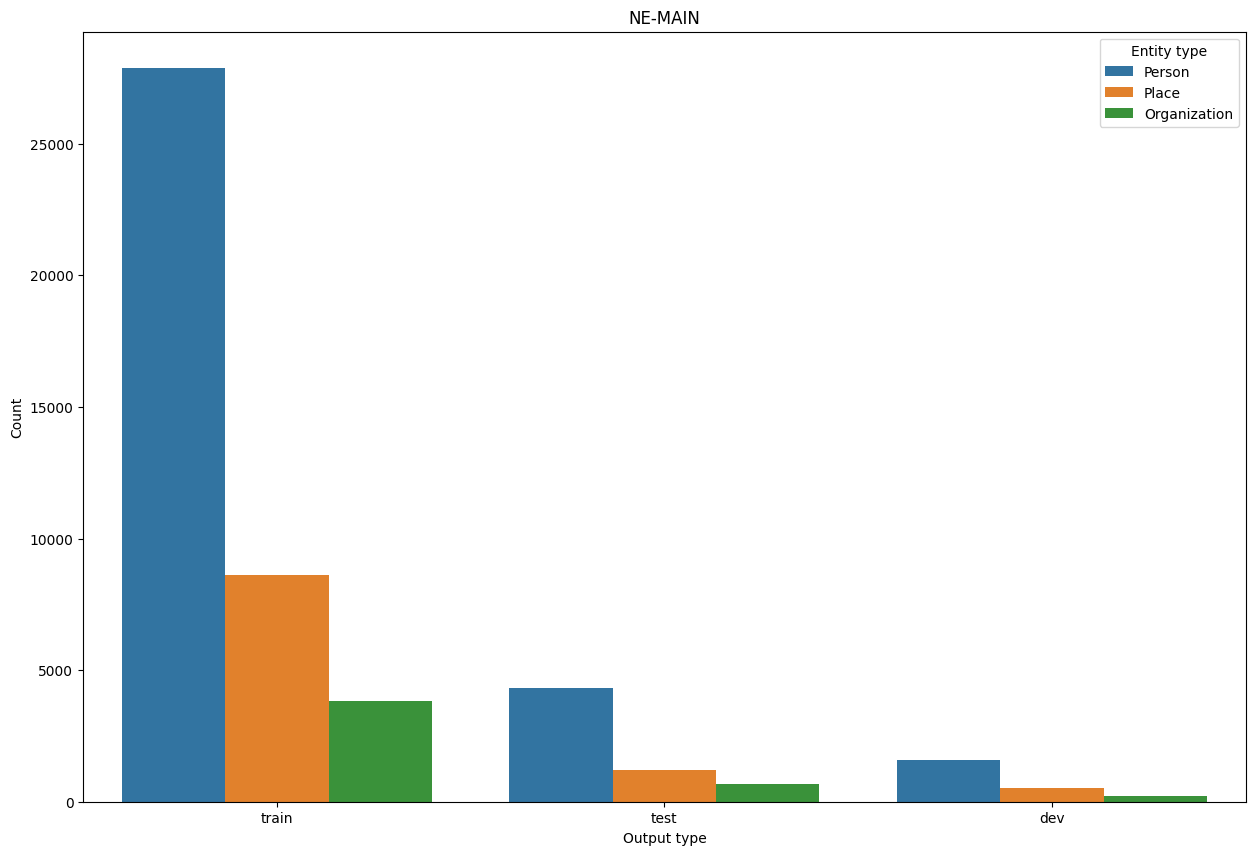

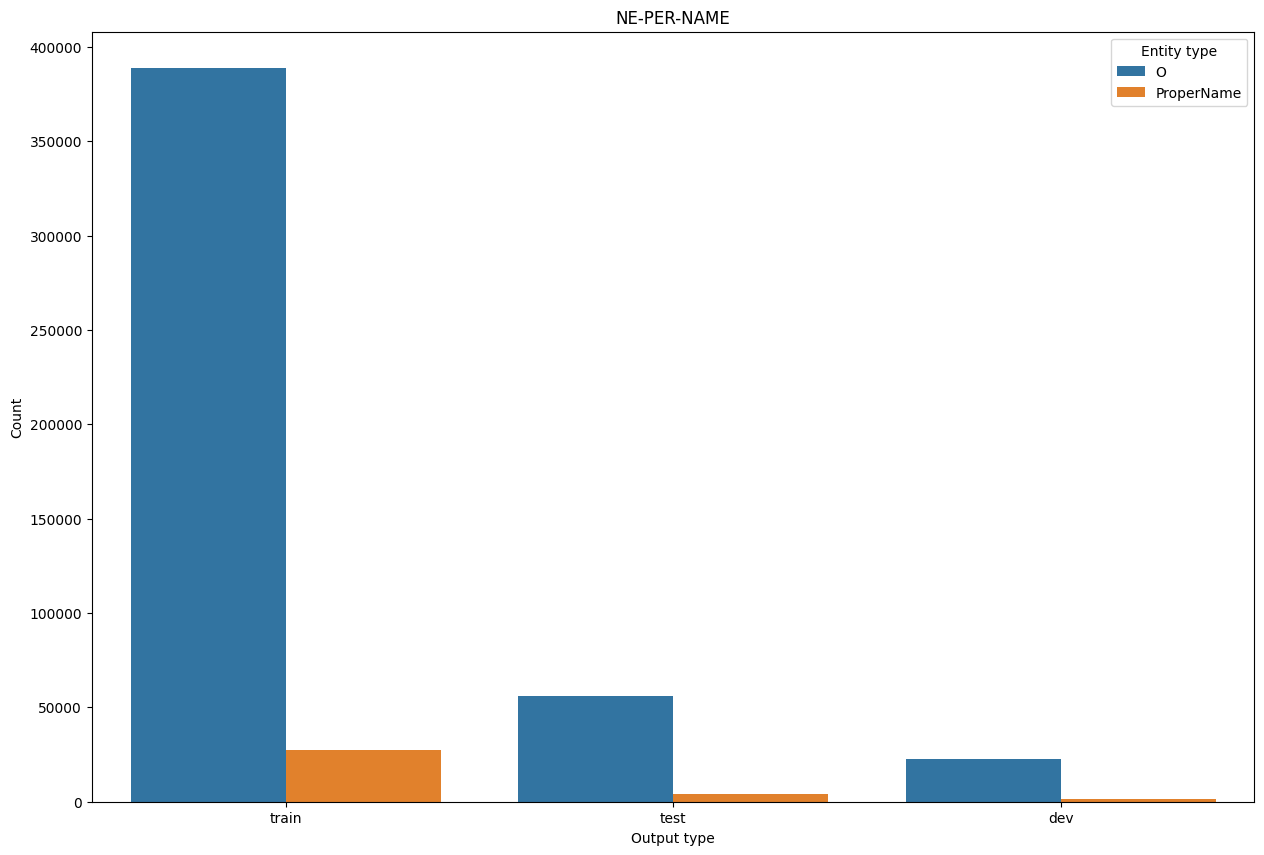

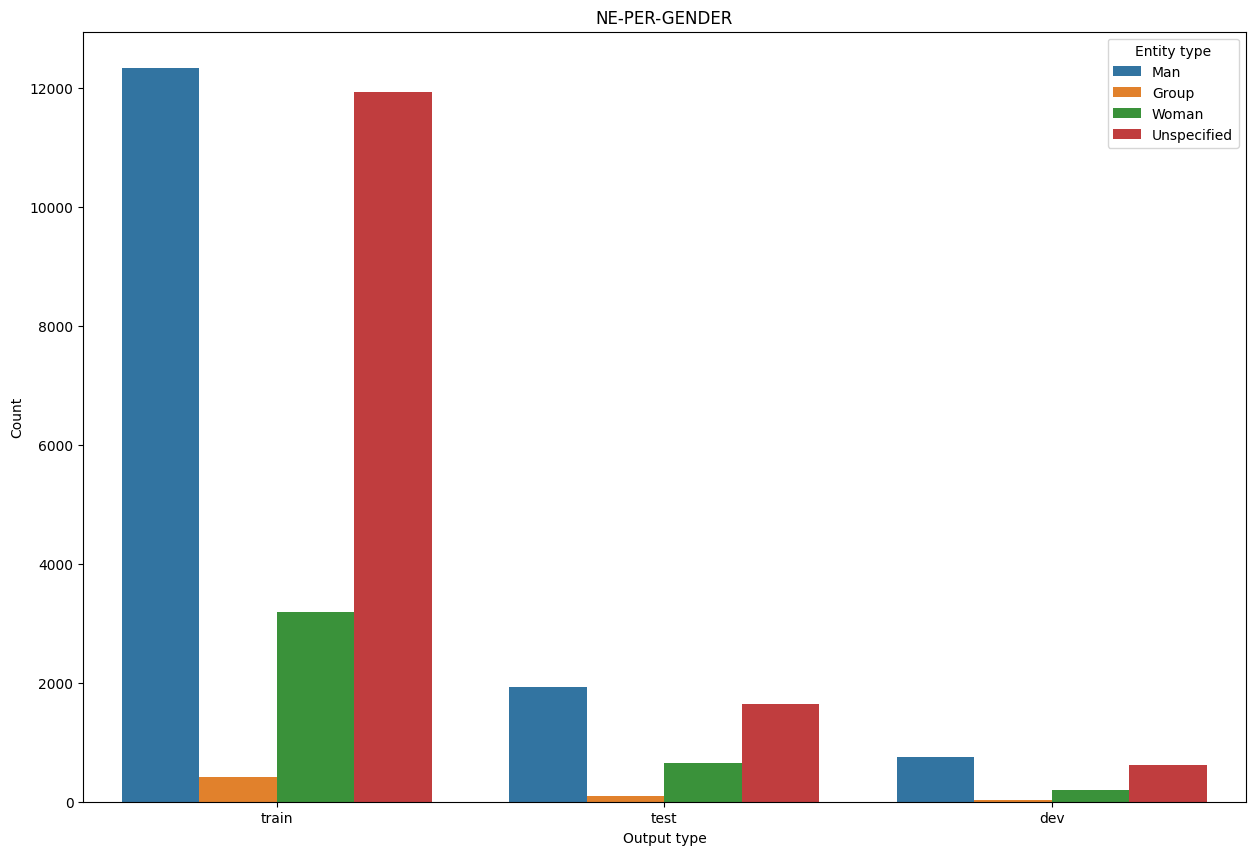

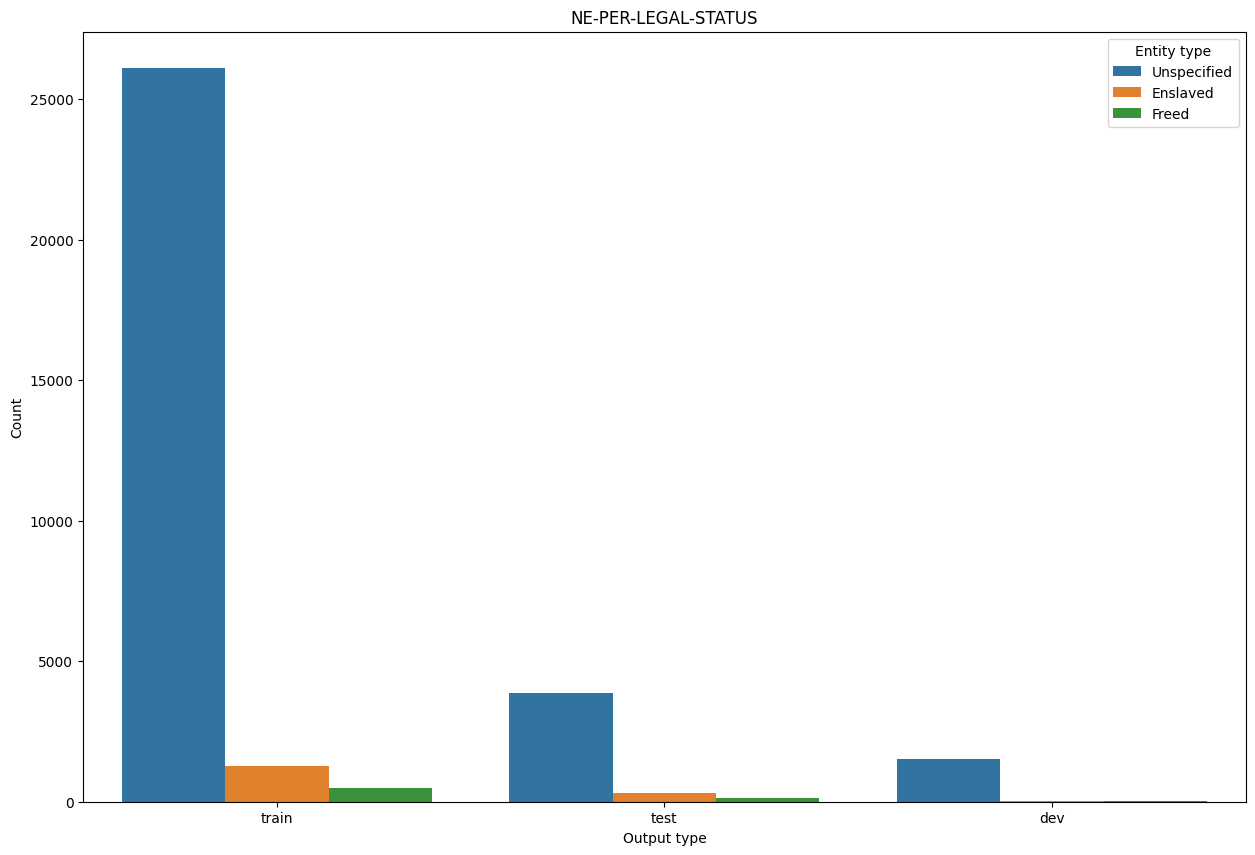

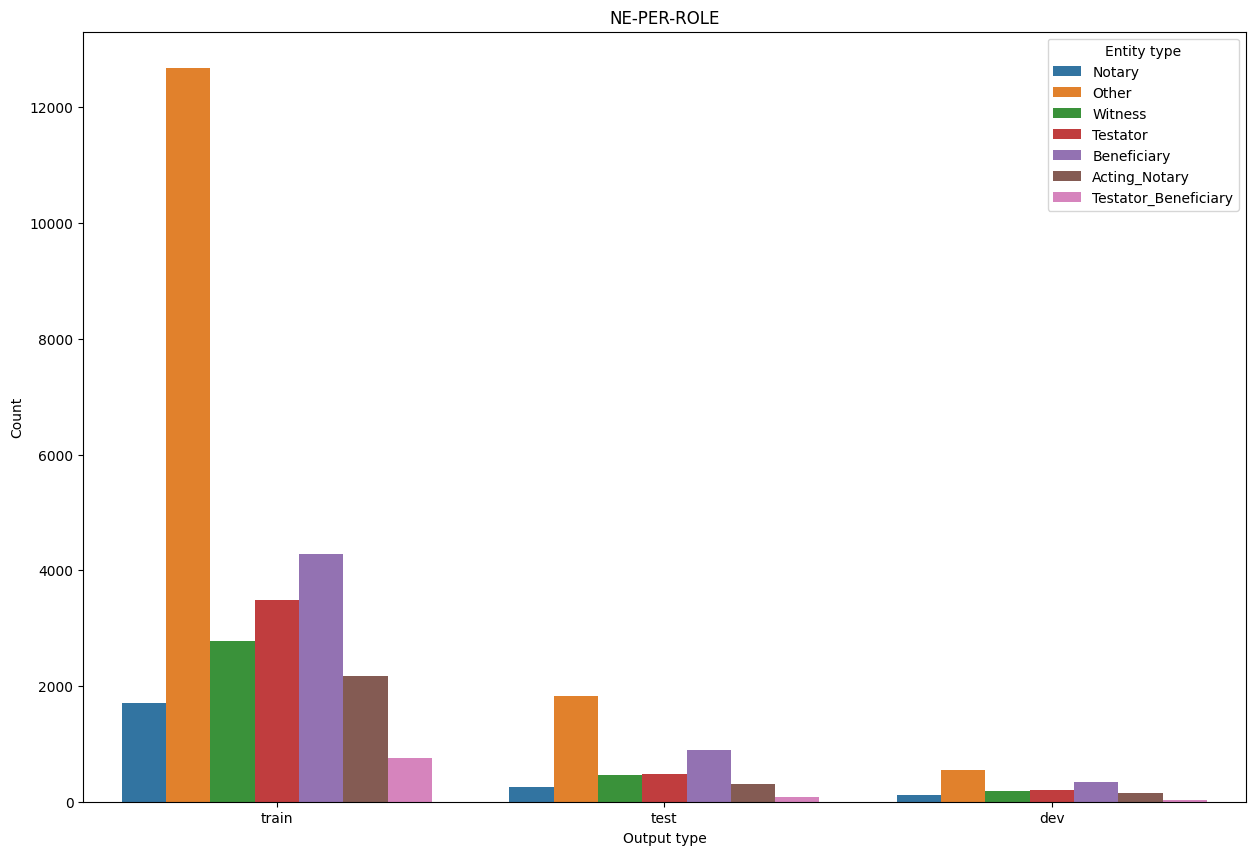

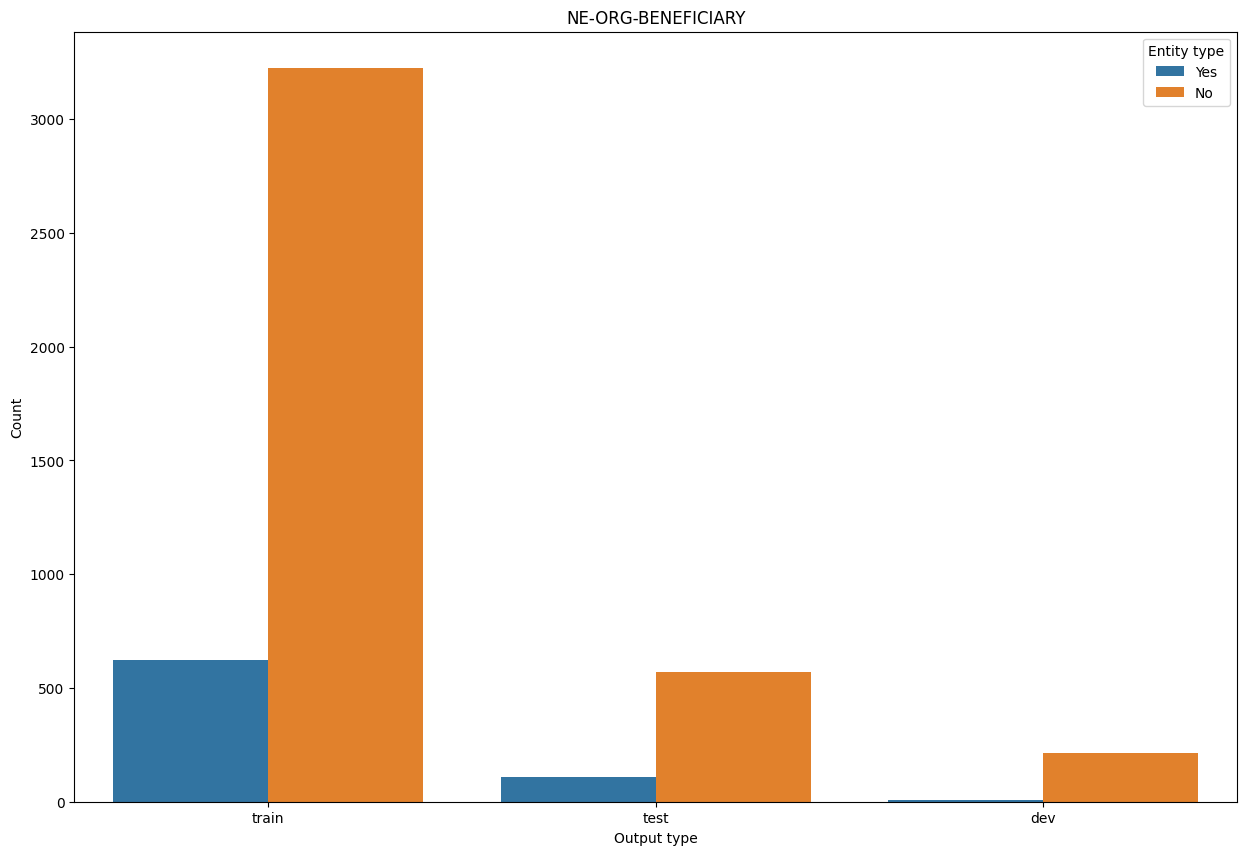

In [56]:
plot_stats(stats)